In [2]:
import fastai
from fastai.text import *
print(fastai.__version__)

1.0.60


In [3]:
#num_workers = 0
%reload_ext autoreload
%autoreload 2
%matplotlib inline
defaults.device = torch.device('cpu')
bs=64
path = Config().data_path()/'giga-nah'
path.ls()

[PosixPath('/Users/ikhalil/.fastai/data/giga-nah/.DS_Store'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/oraciones_clean2.csv'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/datasetJW.csv.bk'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/datasetJW.csv'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/models'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/RNNresults.csv'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/oraciones.csv'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/Trans_results.csv'),
 PosixPath('/Users/ikhalil/.fastai/data/giga-nah/tmp')]

## Load data

We reuse the same functions as in the translation notebook to load our data.

In [4]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

In [5]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [5]:
df = pd.read_csv(path/'oraciones_clean2.csv')
df['Esp'] = df['Esp'].apply(lambda x:x.lower())
df['Nah'] = df['Nah'].apply(lambda y:y.lower())
from sklearn.utils import shuffle
df = shuffle(df)
df = df.reset_index(drop=True)
df = shuffle(df)
df = df.reset_index(drop=True)
df.head()

,Esp,Nah
0,ayan esta dicha casa para ellas con cargo que ...,yntech nicpouhtiuh niquimacatiuh ynic ye niqui...
1,le dijo,kiilui
2,estoy encantado con su trabajo,miac nechpactia motequi
3,el señor virrey don juan de mendoza y luna mar...,auh ynic cenca omomauhti omotequipacho yn tlah...
4,lo qual le mando y doy en pago del dinero que ...,ye nictlaixiptlaiotilia yn ipampa ytomin nicpo...


In [5]:
tokenizer = Tokenizer(SpacyTokenizer, 'es')

processorSpicy = [
    TokenizeProcessor(tokenizer),
    NumericalizeProcessor(ds= None, vocab = None, min_freq=1)
]

tokenizer2 = Tokenizer(SpacyTokenizer, 'nah')
processorSpicy2 = [
    TokenizeProcessor(tokenizer2),
    NumericalizeProcessor(ds= None, vocab = None, min_freq=1)
]

import sentencepiece as spm
processor = SPProcessor(
    lang='en', 
    char_coverage=1.0,
    tmp_dir='tmp', 
    enc='utf8', 
    vocab_sz=1064,
    include_eos=False
)

processor2 = SPProcessor(
    lang='es', 
    char_coverage=1.0,
    tmp_dir='tmp_2', 
    enc='utf8', 
    vocab_sz=8000,
    include_eos=False
)

In [6]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList#(df, 1, ' ', processor)

In [14]:
#Nah -> Esp
src = Seq2SeqTextList.from_df(df, path = path, cols='Nah', processor=processor).split_by_rand_pct(valid_pct=0.10).label_from_df(cols='Esp', label_cls=TextList, processor=processor2)

In [8]:
#Esp -> Nah
src = Seq2SeqTextList.from_df(df, path = path, cols='Esp', processor= processor2).split_by_rand_pct().label_from_df(cols='Nah', label_cls=TextList, processor=processor)

In [9]:
len(src.x.vocab.itos), len(src.y.vocab.itos)

(8000, 1064)

In [10]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 95)

90.0

In [11]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 95)

122.0

In [12]:
src = src.filter_by_func(lambda x,y: len(x) > 120 or len(y) > 120)

In [13]:
len(src.train) + len(src.valid)

16942

In [14]:
data = src.databunch(num_workers=8)

In [15]:
data.save('Ax_Sentence2_es_data.pkl')

Can load from here when restarting.

In [61]:
dataN = load_data('/Volumes/iKhalil 64G/NMT/Transformers/Axolotl/Sentence/nah/0.554888', 'Axolotl_sentenceP_data.pkl')
dataS = load_data('/Volumes/iKhalil 64G/NMT/Transformers/Axolotl/Sentence/spa/0.503683', 'Axolotl_sentenceP_esp_data.pkl')

In [64]:
len(dataN.vocab.itos),len(dataS.y.vocab.itos)

(13496, 13584)

In [17]:
data#.show_batch()

Seq2SeqDataBunch;

Train: LabelList (13539 items)
x: Seq2SeqTextList
▁xxbos ▁le ▁dijo,▁xxbos ▁estoy ▁encantado ▁con ▁su ▁trabajo,▁xxbos ▁el ▁señor ▁virrey ▁don ▁juan ▁de ▁mendoza ▁y ▁luna ▁marqués ▁de ▁montesclaros ▁estaba ▁por ▁ello ▁muy ▁espanta do ▁y ▁preocupado,▁xxbos ▁lo ▁qual ▁le ▁mando ▁y ▁ doy ▁en ▁pago ▁del ▁dinero ▁que ▁le ▁per d í ▁de ▁que ▁ella ▁lo ▁ha ▁por ▁bien ▁y ▁es ▁contenta ▁dello ▁y ▁fuimos ▁concertado s ▁en ▁presencia ▁de ▁mucha ▁gente ▁en ▁el ▁dicho ▁pedazo ▁de ▁tierra ▁tlalmantli ▁que ▁así ▁le ▁ doy ▁y ▁para ▁que ▁de ▁aquí ▁adelante ▁no ▁trate mos ▁de ▁ello,▁xxbos ▁termina ▁el ▁año ▁tochtli
y: TextList
▁xxbos ▁ki i l ui,▁xxbos ▁miac ▁nech pa c tia ▁mo tequi,▁xxbos ▁auh ▁ynic ▁cenca ▁omo mauhti ▁omo tequi pacho ▁yn ▁tlahtohuani ▁visurrey ▁don ▁juan ▁de ▁me n do ça ▁y ▁ lu na ▁marqués ▁de ▁mo nte s c la ro s,▁xxbos ▁ye ▁nic tla i xi p tla i o ti lia ▁yn ▁ipampa ▁y to mi n ▁nic po lo ▁yc ▁y i o llo pa chiuh ▁ pa c ca ▁yo cu xca ▁te ix pan ▁qui ce lia ▁yn ▁tlal man tl

## Transformer model

In [ ]:
data.vocab.stoi['▁no']

### Shifting

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning.

In [8]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [20]:
data.add_tfm(shift_tfm)

### Embeddings

The input and output embeddings are traditional PyTorch embeddings (and we can use pretrained vectors if we want to). The transformer model isn't a recurrent one, so it has no idea of the relative positions of the words. To help it with that, they had to the input embeddings a positional encoding which is cosine of a certain frequency:

In [9]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

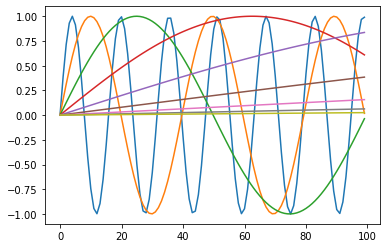

In [10]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,10): ax.plot(res[:,i])

In [11]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz:int, emb_sz:int, inp_p:float=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Feed forward

The feed forward cell is easy: it's just two linear layers with a skip connection and a LayerNorm.

In [13]:
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

### Multi-head attention

In [14]:
class MultiHeadAttention(nn.Module):
    "MutiHeadAttention."
    
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, seq_len, -1)
        
    def _attention_einsum(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # Permute and matmul is a little bit faster but this implementation is more readable
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        attn_score = torch.einsum('bind,bjnd->bijn', (wq, wk))
        if self.scale: attn_score = attn_score.mul_(1/(self.d_head ** 0.5))
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=2))
        attn_vec = torch.einsum('bijn,bjnd->bind', (attn_prob, wv))
        return attn_vec.contiguous().view(bs, seq_len, -1)

### Masking

The attention layer uses a mask to avoid paying attention to certain timesteps. The first thing is that we don't really want the network to pay attention to the padding, so we're going to mask it. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens we're not supposed to see yet (otherwise it would be cheating).

In [15]:
def get_padding_mask(inp, pad_idx:int=1):
    return None
    return (inp == pad_idx)[:,None,:,None]

In [16]:
def get_output_mask(inp, pad_idx:int=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].bool()
    return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

Example of mask for the future tokens:

In [17]:
torch.triu(torch.ones(10,10), diagonal=1).bool()

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

### Encoder and decoder blocks

In [18]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, mask:Tensor=None): return self.ff(self.mha(x, x, x, mask=mask))

In [19]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
    
    def forward(self, x:Tensor, enc:Tensor, mask_in:Tensor=None, mask_out:Tensor=None): 
        y = self.mha1(x, x, x, mask_out)
        return self.ff(self.mha2(y, enc, enc, mask=mask_in))

### The whole model

In [20]:
class Transformer(nn.Module):
    "Transformer model"
    
    def __init__(self, inp_vsz:int, out_vsz:int, n_layers:int=6, n_heads:int=8, d_model:int=256, d_head:int=32, 
                 d_inner:int=1024, inp_p:float=0.1, resid_p:float=0.1, attn_p:float=0.1, ff_p:float=0.1, bias:bool=True, 
                 scale:bool=True, double_drop:bool=True, pad_idx:int=1):
        super().__init__()
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_in  = get_padding_mask(inp, self.pad_idx)
        mask_out = get_output_mask (out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        for enc_block in self.encoder: enc = enc_block(enc, mask_in)
        for dec_block in self.decoder: out = dec_block(out, enc, mask_in, mask_out)
        return self.out(out)

#### Bleu metric (see dedicated notebook)

In [21]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [22]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [23]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [24]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training

In [39]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos))#, d_model=256, d_inner=1024)

In [40]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func = CrossEntropyFlat())

In [ ]:
learn.lr_find()

Min numerical gradient: 1.91E-02
Min loss divided by 10: 6.31E-02


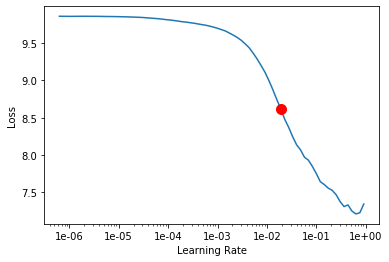

In [30]:
learn.recorder.plot(skip_end=7,suggestion=True)

In [ ]:
#learn.fit_one_cycle(30, 5e-4, div_factor=5)
learn.fit_one_cycle(40, 4.1416e-4, div_factor=5)

In [41]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [42]:
inputs, targets, outputs = get_predictions(learn)

In [43]:
inputs[10],targets[10],outputs[10]

(Text ▁xxbos ▁ken ▁inemilis ▁in ▁altepemej ▁mo se ua lti n ▁mo pano lti a ▁ni n ▁ ueue tla l to l li ▁xiuitl ▁in ▁xiuitl ▁amo ▁kimati ▁tlen ▁xiuitl ▁o k ix e x e lo ke ▁in ▁ po z a ▁de l ▁pa d re ▁ni an ▁amo ▁ma chi s ti ▁in ▁ tok a yotl ▁in ▁ta ta s ▁uan ▁na na s ▁amo no ▁ma chi s ti ▁keni n ▁o ti tok e ▁in ik ▁ompa ▁mo tlaka ita k a ▁mi e k ti n ▁xi ui mej ▁teipa k,
 Text xxbos como las costumbres de los pueblos indígenas se van xxunk de generación en generación no se sabe con precisión en que año escogieron la poza del padre ni los nombres de los tatas y nanas tampoco se sabe como xxunk para que ese lugar fuera respetado por muchos años después,
 Text xxbos en en personas de la pueblos indígenas la corresponde a a su malvada su malvada para refiere con su para el el el de obra para servicio en la días de la días la seguridad la en vida que la de la usted día la de xxpad los hombres xxpad de)

In [44]:
inputs[300],targets[300],outputs[300]

(Text ▁xxbos ▁ maske ▁amo ▁kinamiki ▁kiampa ▁panos ▁ipan ▁ininchaj ▁kinchiuili aj ▁tlen ▁amo ▁kuali ▁uelis ▁kin i tski a ▁se ▁tlen ▁ichampoyouaj ▁o ▁i te ix ma t kauaj ▁o ▁se ▁akajya ▁katli ▁kuali ▁mouika ▁ininuaya ▁ininuampoyouaj,
 Text xxbos por desgracia muchos abusos ocurren en el hogar y quienes los cometen suelen ser parientes cercanos y amigos de la familia,
 Text xxbos aunque supuesto no casos sexuales desastres una lugar pero quizás no ponen pecados tener expulsados o tal de de esa familia o)

In [45]:
inputs[701],targets[701],outputs[701]

(Text ▁xxbos ▁ipan ▁ni ▁tonali ▁katli ▁motemachi aj ▁ya sej ▁iluikak ▁uan ▁tojuantij ▁katli ▁timotemachi aj ▁tiitstosej ▁nochipa ▁ipan ▁tlaltipaktli ▁tijchiuaj ▁kampeka ▁amo ▁timajmaui sej ▁kej ▁ya,
 Text xxbos hoy día tanto las personas ungidos como las otras ovejas nos esforzamos por imitar su valor,
 Text xxbos hoy día los los personas fieles como él que ovejas esperamos sentiremos por seguir el ejemplo como)

In [46]:
inputs[1005],targets[1005],outputs[1005]

(Text ▁xxbos ▁¿ kenke ▁tlauel ▁moneki ▁amo ▁timajmaui sej ▁uan ▁amo ▁timo k a ma tsakua sej ▁kema ▁moneki s ▁tikamanalti sej ?,
 Text xxbos ¿ por qué es tan importante que seamos valientes y hablemos cuando sea necesario ?,
 Text xxbos ¿ por qué es tan importante que seamos valientes y no con hablamos necesario ?)

In [47]:
inputs[360],targets[360],outputs[360]

(Text ▁xxbos ▁nopa ▁tlanauatili ▁nojkia ▁kinmokuitlaui yaya ▁maseualmej ▁ininchampoyouaj ▁pampa ▁amo ▁kikaua yaya ▁se ▁siuatl ▁o ▁se ▁tlakatl ▁ma ▁moteka ▁iuaya ▁se ▁akajya ▁katli ▁eliyaya ▁i uik al ▁o ▁i te ix ma t k a,
 Text xxbos a fin de proteger a las familias la ley prohibía todo tipo de xxunk es decir las relaciones sexuales entre parientes cercanos,
 Text xxbos la la de cuentas la la personas la mujer del o el para menores para un los normas sexuales entre alguien o)

### Label smoothing

They point out in the paper that using label smoothing helped getting a better BLEU/accuracy, even if it made the loss worse.

In [37]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos))#, d_model=128, d_inner=512, n_heads=8, d_head=16)

In [38]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [44]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 2.09E-02


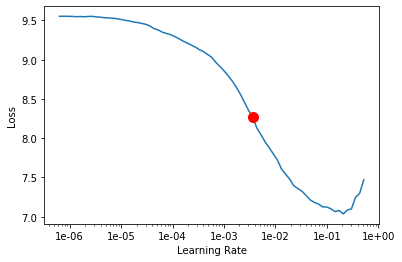

In [45]:
learn.recorder.plot(skip_end=7, suggestion=True)

In [39]:
learn.model.train()
#learn.fit_one_cycle(50, 5e-3, div_factor=5)
#learn.fit_one_cycle( , 1.51E-03)#, div_factor=5)
learn.fit_one_cycle(50,  2.7182E-04, div_factor=25)
#learn.fit_one_cycle(1, 1e-2)#, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,5.311355,5.364151,0.502197,0.444993,13:52
1,4.422385,4.577450,0.502197,0.444993,14:26
2,3.520900,3.775075,0.508663,0.447010,14:32
3,3.043933,3.498248,0.542522,0.453537,15:48
4,2.872254,3.391088,0.546568,0.452775,16:22
5,2.853875,3.241101,0.554746,0.460754,15:13
6,2.811629,3.134019,0.564476,0.463384,16:04
7,2.730990,3.054522,0.572843,0.470533,13:58
8,2.649108,2.971254,0.582016,0.476440,14:27
9,2.598235,2.879090,0.594301,0.485072,13:43


In [39]:
learn.model.train()
#learn.fit_one_cycle??
#learn.fit_one_cycle(50, 3.1415E-04, div_factor=50)
#learn.fit_one_cycle(50, 9.4247E-04, div_factor=64)
#learn.fit_one_cycle(50,  2.7182E-04, div_factor=50)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,8.052568,7.967494,0.493168,0.509761,25:48
1,6.207025,6.191325,0.538649,0.516770,26:50
2,4.193237,4.393533,0.538649,0.516770,26:44
3,3.615576,3.892571,0.577055,0.534887,26:37
4,3.353209,3.685606,0.598524,0.544775,25:51
5,3.219417,3.509509,0.621578,0.552339,28:54
6,3.177646,3.376096,0.641121,0.561760,27:03
7,3.032282,3.240584,0.655671,0.566757,27:01
8,2.928368,3.139752,0.667841,0.571508,27:20
9,2.822839,3.063716,0.679342,0.579471,27:19


In [ ]:
inputs[60],targets[60],outputs[60]

In [ ]:
inputs[10],targets[10],outputs[10]

In [ ]:
inputs[700],targets[700],outputs[700]

In [ ]:
inputs[701],targets[701],outputs[701]

In [ ]:
inputs[400],targets[400],outputs[400]

In [40]:
learn.model.eval();
learn.export('Ax_Sentence2_es.pkl')
learn.save('Ax_Sentence2_es')

In [25]:
def convertToTensor(phrase,target_language=False):
    arrayT = []
    arrayT.append(data.x.vocab.stoi["xxbos"])
    for word in phrase.split():
        if target_language:
            token = data.y.vocab.stoi[word]
        else:
            token = data.x.vocab.stoi[word]
        #print("word: " + word + " token: " + str(token))
        arrayT.append(token)
    return torch.tensor([arrayT])

In [26]:
def translate(phrase, tokenizer = 'Spicy'):
    phrase = phrase.lower()
    transaltionVector = []
    finalT = []
    if tokenizer == 'Spicy' or tokenizer == 'Sentence_rev':
        transaltionVector = [2] #xxbos token
        finalT = convertToTensor(phrase)
    else:
        transaltionVector = [2] #xxbos token
        #d = {'Nah': [phrase,data.y.vocab.stoi["_xxbos"]]}
        #dfT = pd.DataFrame(data=d)
        #input2 = TextList.from_df(dfT, path = path, cols='Nah', processor= processor).split_by_rand_pct(seed=42).label_for_lm()
        #input2.databunch(bs=128, num_workers=1)
        #phrase = input2.x[0].text
        finalT = torch.tensor([processor.process_one(phrase)][:1])
        #print(finalT)
    
    lastCount = 0
    
    while lastCount < len(transaltionVector):
        #print(finalT)
        #print(torch.tensor([transaltionVector]))
        test = learn.model(
            finalT,
            torch.tensor([transaltionVector])
        )
        outputs = []
        for z in zip(test):
            outputs.append(learn.data.train_ds.y.reconstruct(z[0].argmax(1)))
        transaltionVector = [2]
        for tokenTarget in outputs[0].data:
            transaltionVector.append(tokenTarget)
        lastCount += 1
        if len(transaltionVector) >= 1000:
            break;
    return outputs[0].text

In [29]:
paht = "/Volumes/iKhalil 64G/NMT/Transformers/JW/Sentence/spa/0.664544/"
learn = load_learner(paht, 'JW_Sentence_es.pkl')
data = load_data(paht, 'JW_Sentence_es_data.pkl')
data.add_tfm(shift_tfm)

In [27]:
paht = "/Volumes/iKhalil 64G/NMT/Transformers/JW/Sentence/spa/0.664544/"
learn = load_learner(paht, 'JW_Sentence_es.pkl')
data = load_data(paht, 'JW_Sentence_es_data.pkl')
data.add_tfm(shift_tfm)
#df1 = pd.read_csv(r'/Users/ikhalil/.fastai/data/giga-nah/datasetJW.csv')
sentences = []
for s in data.valid_ds:
    txt = s[0].text
    #txt = txt.replace('xxbos ', '')
    txt = txt.replace('▁xxbos ', '')
    txt = txt.replace(' ', '')
    txt = txt.replace('▁', ' ')
    txt = txt[1:]
    sentences.append(txt)
processor = SPProcessor.load(paht + "vocab")
sentences[0:5]

['canto a xipe tótec yohualahuana',
 'es enredadera kuamekatsin',
 'y sí también te vas a pegar',
 'el lunes de septiembre de fiesta de san miguel llegó y entró a la ciudad de méxico tenochtitlan el muy reverendo señor don fray garcía guerra religioso de santo domingo y arzobispo de méxico que ahora nos gobierna espiritualmente en tenochtitlan como sexto arzobispo de méxico',
 'lo que se come es amarillo eso es lo que se hierve el guisado sale muy amarillo parece yema de huevo huele muy sabroso y es grasoso como caldo de pollo la pulpa se hierve con agua se le pone ajonjolí y hoja de pimienta']

In [462]:
i = 0
new_sentences = []
for sentence in sentences:
    new_sentences.append(translate(sentence, "sentence"))#"sentence"
    if i < 5:
        print(new_sentences[i])
    i+=1

▁xi hual huica can ▁xi cuil to no hua hua hua hua
1
▁in ▁kua me ka t
2
▁uan ▁ken a ▁ne ▁ti j pe na s ▁no j a
3
▁axcan ▁lunes ▁yn ▁ic ▁mani ▁metztli ▁se p t iembre ▁de ▁años ▁y hcuac ▁yancuic an ▁ ylhuitzin ▁sant ▁miguel ▁de s t he o ▁ynic ▁cenca ▁mahuiztililoni ▁teoyotica ▁tlahtohuani ▁mexico ▁tenochtitlan ▁cenca ▁mahuiztililoni ▁teoyotica ▁tlahtohuani ▁arçobispo ▁mexico ▁tenochtitlan ▁cenca ▁mahuiztililoni ▁teoyotica ▁tlahtohuani ▁don ▁fray ▁ ga r c ía ▁ ga r c ía ▁ g ue r ra ▁arçobispo ▁mexico ▁tenochtitlan ▁ynin ▁yc nahui ntin ▁mo huica tza ▁yn ▁teoyotica ▁tlahtohuani ▁arçobispo ▁mexico ▁tenochtitlan
4
▁in ▁ co m á s ▁ co z i tl ▁in ▁ye ▁cualli ▁qui mana ▁in ▁pi lan yo n ▁in ▁ co z tic ▁in ▁cenca yo ▁in ▁i a yo ▁in ▁cenca h ▁ quiza ya k ua ya k pa yo ▁iuan ▁ce mana ▁ co mo l co mo lli ▁in ▁a ko li pe tla tl ▁i juak a a yo ▁mo pa ta tia ▁ya ▁in ▁a ko li uia c ▁uan ▁ya ▁in ▁ye c yo
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
4

1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883


3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
